In [132]:
import polars as pl
import numpy as np
import os
import matplotlib.pyplot as plt
import emd
from dtw import *
from utils import *
from plotters import *

time = []
fs = []
hr = []
mx = []

# Recordings files paths
path = os.getcwd() + r"\data_healthy"
file_paths = sorted([os.path.join(path, file) for file in os.listdir(path)], key=extract_recording_number)

# Read data from the files
for file_path in file_paths:
    df = pl.read_csv(file_path, separator=";", decimal_comma=True)
    t_hat, _ = convert_datetime_to_time(df["DateTime"].to_numpy())
    time.append(t_hat)
    hr.append(df["hr"].to_numpy())
    if df["FVL"].mean() > df["FVR"].mean():
        mx.append(df["mx_l"].to_numpy())
    else:
        mx.append(df["mx_r"].to_numpy())

# Standard min/max norm
# hr = [np.interp(h, (h.min(), h.max()), (0, 1)) for h in hr]
# mx = [np.interp(m, (m.min(), m.max()), (0, 1)) for m in mx]

# Z-score normalization
# hr = [(h - np.mean(h)) / np.std(h) for h in hr]
# mx = [(m - np.mean(m)) / np.std(m) for m in mx]

# Each file has the same fs, thus there is no need to iterate over files
# A priori T = 10s
# sample_rate = 1 / np.mean(np.diff(time[0]))

In [133]:
file_number = 27

Text(0.5, 1.0, 'Sum of 2nd, 3rd, and 4th IMFs')

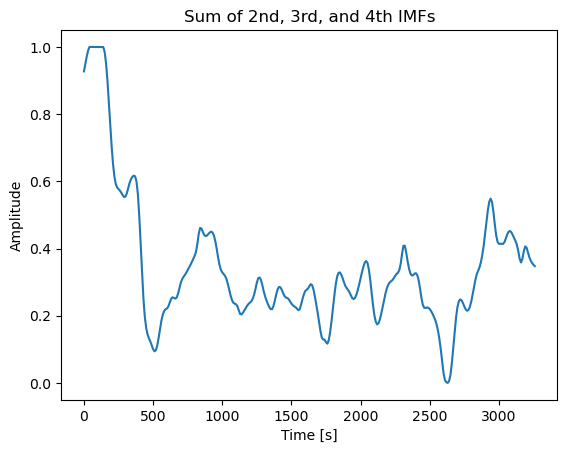

In [134]:
# Apply EMD
imf_mx = emd.sift.sift(mx[file_number])
# emd.plotting.plot_imfs(imf_mx, time_vect=time[file_number], xlabel="Time [s]")
# print("IMF shape:", imf_mx.shape)
# Number of imf-s
n = imf_mx.shape[1]
# Residual + 2 last imf-s
imf_mx = imf_mx[:, n - 3] + imf_mx[:, n - 2] + imf_mx[:, n - 1]

imf_hr = emd.sift.sift(hr[file_number])
# emd.plotting.plot_imfs(imf_hr, time_vect=time[file_number], xlabel="Time [s]")
n = imf_hr.shape[1]
# Exclude first imf
imf_hr = np.sum(imf_hr[:, 1:], axis=1)

## Standard min/max norm
imf_hr = (imf_hr - np.min(imf_hr)) / (np.max(imf_hr) - np.min(imf_hr))
imf_mx = (imf_mx - np.min(imf_mx)) / (np.max(imf_mx) - np.min(imf_mx))

# Z-score normalization
# imf_hr = (imf_hr - np.mean(imf_hr)) / np.std(imf_hr)
# imf_mx = (imf_mx - np.mean(imf_mx)) / np.std(imf_mx)

# Plot the sum of the IMFs
plt.plot(time[file_number], imf_mx)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Sum of 2nd, 3rd, and 4th IMFs")

<Axes: xlabel='Query index', ylabel='Reference index'>

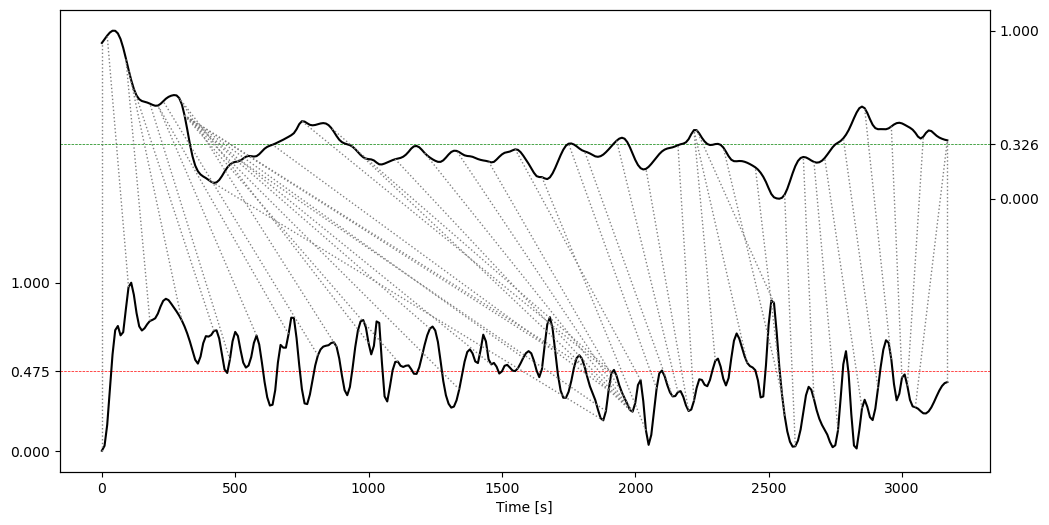

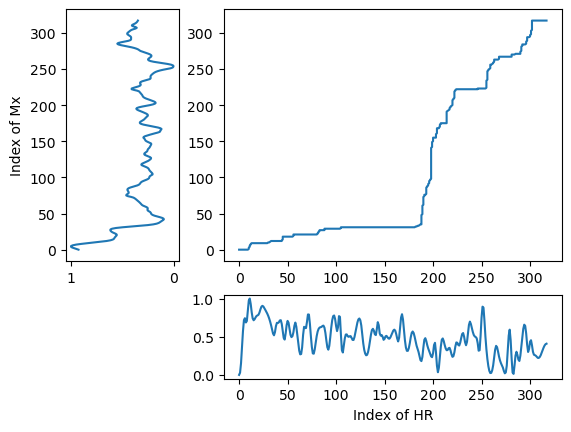

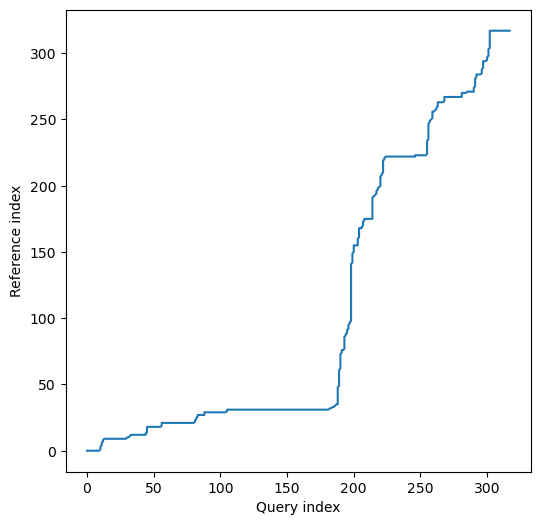

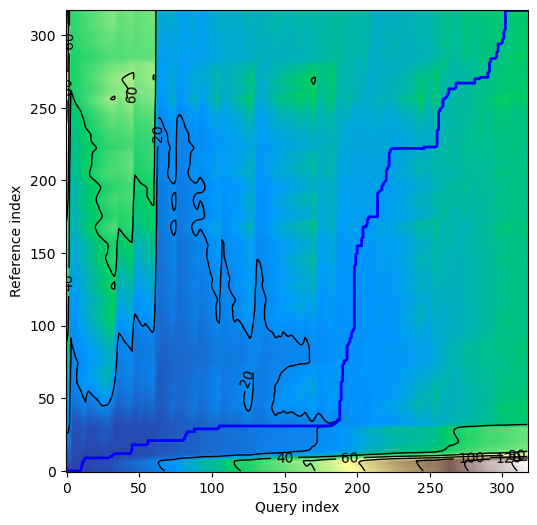

In [135]:
# Apply DTW to imf_sum and hr
alignment = dtw(imf_hr, imf_mx, keep_internals=True)

# ``twoway`` plots a point-by-point comparison, with matching lines
customDtwPlotTwoWay(alignment, offset=1.5, xlab="Time [s]")
plt.savefig(f"D:\\_PracaDyplomowa\\plots\\DTW_twoway_{file_number}.pdf")

# ``threeway`` vis-a-vis inspection of the timeseries and their warping
#    curve; see [dtwPlotThreeWay()]
alignment.plot(type="threeway", xlab="Index of HR", ylab="Index of Mx")

# ``alignment`` plots the warping curve in ``d``
alignment.plot(type="alignment")

# ``density`` displays the cumulative cost landscape with the warping
#    path overimposed; see [dtwPlotDensity()]
alignment.plot(type="density")

<Axes: >

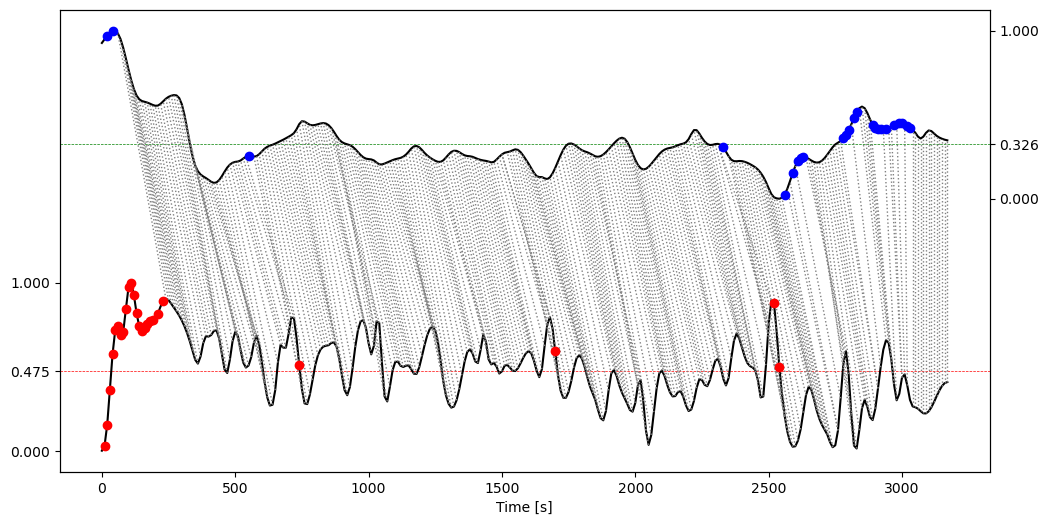

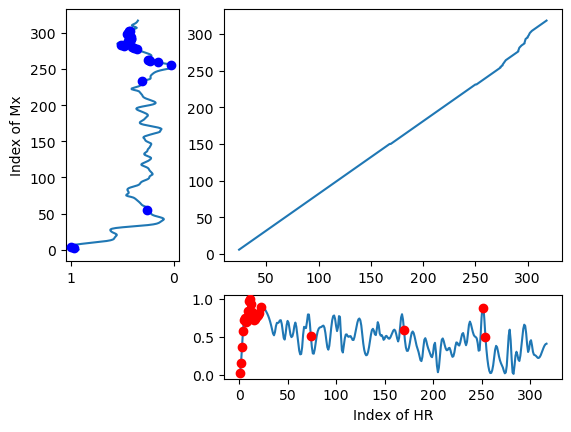

In [136]:
zx_costs, x_drop_costs, z_drop_costs = compute_all_costs(
    series1=imf_hr, 
    series2=imf_mx, 
    drop_cost_type="percentile", 
    percentile=75
)

min_cost, matched_indices, dropped1, dropped2 = double_drop_dtw(
    costs=zx_costs,
    drop_costs1=x_drop_costs,
    drop_costs2=z_drop_costs,
    contiguous=True
)

dropDtwPlotTwoWay(
    xts=imf_hr,
    yts=imf_mx,
    xlab="Time [s]",
    offset=1.5,
    matched_indices=matched_indices,
    dropped1=dropped1,
    dropped2=dropped2
)

dropDtwPlotThreeWay(
    xts=imf_hr,
    yts=imf_mx,
    xlab="Index of HR",
    ylab="Index of Mx",
    matched_indices=matched_indices,
    dropped1=dropped1,
    dropped2=dropped2
)

In [137]:
print(f"Alignment distance for series {file_number}: {alignment.distance}")
normalized_distance = alignment.distance / (len(imf_hr) + len(imf_mx))
print(f"Normalized distance for series {file_number}: {normalized_distance}")
print(f"Minimum cost for series {file_number}: {min_cost}")

Alignment distance for series 27: 36.80628771645139
Normalized distance for series 27: 0.05787152156674748
Minimum cost for series 27: 67.24605442730595
